<a href="https://colab.research.google.com/github/dan-a-iancu/airm/blob/master/Alset_Motors/Alset_Motors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements the solution to the **Alset Motors** mini-case. It assumes you are familiar with the case and the model.

____
# Basic Setup

Import useful modules, read the data and store it in data frames, and set up some useful Python lists. You may want to expand this section and make sure you understand how the data is organized, and also read the last part where the Python lists are created, as these may be very useful when you build your model.

In [ ]:
#@markdown We first import some useful modules. 

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# import numpy
import numpy as np
import urllib.request  # for file downloading

# Import pandas for data-frames
import pandas as pd
pd.options.display.max_rows = 15
pd.options.display.float_format = "{:,.2f}".format

from IPython.display import display

# Make sure Matplotlib runs inline, for nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.ticker as ticker 

# install Gurobi (our linear optimization solver)
!pip install -i https://pypi.gurobi.com gurobipy
from gurobipy import *

# some modules to create local directories for CBC (to avoid issues with solving multiple models)
import os
def new_local_directory(name):
    full_path = os.path.join(".", name)
    os.makedirs(full_path, exist_ok=True)
    return full_path

# install the latest version of seaborn for nicer graphics
#!pip install --prefix {sys.prefix} seaborn==0.11.0  &> /dev/null
import seaborn as sns

# Ignore useless some warnings
import warnings
warnings.simplefilter(action="ignore")

print("Completed successfully!")

Looking in indexes: https://pypi.gurobi.com
Completed successfully!


## Load the case data into Pandas data frames

We first download an Excel file with all the data from Github.

In [ ]:
#@markdown Download the entire data as an Excel file from Github

url_Excel = 'https://raw.githubusercontent.com/dan-a-iancu/airm/master/Alset_Motors/Alset_Motors_Data.xlsx?raw=true'
local_file = "Alset_Motors_Data.xlsx"   # name of local file where you want to store the downloaded file
urllib.request.urlretrieve(url_Excel, local_file)    # download from website and save it locally

('Alset_Motors_Data.xlsx', <http.client.HTTPMessage at 0x7f6e88dd3dd0>)

Read in and store the data in suitable dataframes.

In [ ]:
#@markdown Create dataframes based on the Excel file

# data on factories (Table 1); "index_col=0" just assigns the first column as the row names of the data frame
factoriesDF = pd.read_excel("Alset_Motors_Data.xlsx", sheet_name = "Factories", index_col=0)
display(factoriesDF)

# costs from factories to customization centers (Table 2)
costsFactoriesToCentersDF = pd.read_excel("Alset_Motors_Data.xlsx", \
                                    sheet_name = "Factories_to_Centers", index_col=0) 
display(costsFactoriesToCentersDF)

# customization center data (Table 3)
customizationCentersDF = pd.read_excel("Alset_Motors_Data.xlsx", sheet_name = "Customization_Centers", index_col=0)
display(customizationCentersDF)

# customer pre-order data (Table 4)
retailersDF = pd.read_excel("Alset_Motors_Data.xlsx", sheet_name = "Retailer_Preorders", index_col=0)
display(retailersDF)

# costs from customization centers to clients (Table 5)
costsCentersToRetailersDF = pd.read_excel("Alset_Motors_Data.xlsx", \
                              sheet_name = "Centers_to_Retailers", index_col=0)
display(costsCentersToRetailersDF)

,Cost,Capacity
Factory,,
Zuffe,54000,5000
Leip,58500,2000


,C1,C2,C3
Zuffe,1000,2500,2000
Leip,2000,1500,1800


,Staffing_Cost,Capacity
C1,3000,2000
C2,6000,2200
C3,7500,3300


,Pre-orders,Price
OO,5000,71000
FL,2500,74000
SH,1600,69000
WW,550,71000


,OO,FL,SH,WW
C1,4000,6000,3000,5000
C2,6000,6000,2000,4500
C3,4500,7000,6000,3000


## Create Python lists based on the data-frames

__NOTE__: Make sure you understand what the __lists__ created here are! These will be very helpful when creating the model.

In [ ]:
#@markdown Create useful lists with the factories, centers, clients
# Calculate some useful lists: the factories, the customization centers, the clients
factories = list( factoriesDF.index )              # the list of factories
centers = list( customizationCentersDF.index )     # the list of customization centers
retailers = list( retailersDF.index )              # the list of retailers

# Take a look at the lists
print("The list of factories:")
print(factories)

print("The list of centers:")
print(centers)

print("The list of retail clients:")
print(retailers)

The list of factories:
['Zuffe', 'Leip']
The list of centers:
['C1', 'C2', 'C3']
The list of retail clients:
['OO', 'FL', 'SH', 'WW']


<font color=red>**IMPORTANT HINT.**</font> When defining your **decision variables** in this model, you may want to consider *matrices* (or grids) of decision variables instead of a simple list like we've created before. Specifically, you may want to add a decision variable for every pair of elements where the first element is from one list and the second element is from another list. 

When the decision variables are organized in a grid, it's significantly easier to use the ``addVars`` function to add all of the decision variables to the model at once. The function ``addVars`` can take as arguments several lists, e.g., `addVars(list1, list2, list3,...)`, in which case it will return one decision variable for every possible tuple of values. These decision variables will be stored as a dictionary, with the dictionary keys corresponding to the tuple of values. 

For instance, suppose `list1 = ["Paris", "Budapest", "Beijing"]` and `list2= [1,2]`. Then `myDecisions = addVars(list1,list2)` would return a dictionary containing one decision for every pair, i.e., ("Paris",1), ("Paris",2), ("Budapest",1), ("Budapest",2), etc. To access the decision corresponding to the pair ("Paris",1), we can simply use `myDecisions[("Paris",1)]` or `myDecisions["Paris",1]`.

_____
# **Q1**

##  Create an empty model

In [ ]:
# Gurobi model
AlsetModel = Model("Alset Motors Supply Chain Model")

Restricted license - for non-production use only - expires 2022-01-13


## Define the Decision Variables
In this problem, we would like to create a decision variable for every pair of (factory,center), and also for every pair of (center,client). This is done easily using Gurobi's ``addVars`` method.

In [ ]:
# decision variables for how much to ship from each factory to each customization center
factoriesToCenters = AlsetModel.addVars( factories, centers , name = "Ship")

print(factoriesToCenters)

# decision variables for how much to ship from each customization center to each client
centersToRetailers = AlsetModel.addVars( centers, retailers , name="Ship")

print(centersToRetailers)

{('Zuffe', 'C1'): <gurobi.Var *Awaiting Model Update*>, ('Zuffe', 'C2'): <gurobi.Var *Awaiting Model Update*>, ('Zuffe', 'C3'): <gurobi.Var *Awaiting Model Update*>, ('Leip', 'C1'): <gurobi.Var *Awaiting Model Update*>, ('Leip', 'C2'): <gurobi.Var *Awaiting Model Update*>, ('Leip', 'C3'): <gurobi.Var *Awaiting Model Update*>}
{('C1', 'OO'): <gurobi.Var *Awaiting Model Update*>, ('C1', 'FL'): <gurobi.Var *Awaiting Model Update*>, ('C1', 'SH'): <gurobi.Var *Awaiting Model Update*>, ('C1', 'WW'): <gurobi.Var *Awaiting Model Update*>, ('C2', 'OO'): <gurobi.Var *Awaiting Model Update*>, ('C2', 'FL'): <gurobi.Var *Awaiting Model Update*>, ('C2', 'SH'): <gurobi.Var *Awaiting Model Update*>, ('C2', 'WW'): <gurobi.Var *Awaiting Model Update*>, ('C3', 'OO'): <gurobi.Var *Awaiting Model Update*>, ('C3', 'FL'): <gurobi.Var *Awaiting Model Update*>, ('C3', 'SH'): <gurobi.Var *Awaiting Model Update*>, ('C3', 'WW'): <gurobi.Var *Awaiting Model Update*>}


## Calculate and add the objective function

In [ ]:
#@markdown Calculate the revenues
revenue = quicksum( centersToRetailers[c,r] * retailersDF["Price"][r] for c in centers for r in retailers )

#@markdown Calculate the costs
# there are four terms: 
# - production costs (at factories)
prodCost = quicksum( factoriesToCenters[f,c] * factoriesDF["Cost"][f] for f in factories for c in centers )

# - handling & transportation costs factories to customization centers
transCost_FC = quicksum( factoriesToCenters[f,c] * costsFactoriesToCentersDF[c][f] for f in factories for c in centers )

# - customization cost (incurred at the customization centers)
customizationCost = quicksum( centersToRetailers[c,r] * customizationCentersDF["Staffing_Cost"][c] \
                             for c in centers for r in retailers )

# - transportation costs customization centers to retail stores
transCost_CR = quicksum( centersToRetailers[c,r] * costsCentersToRetailersDF[r][c] for c in centers for r in retailers )

# total
totalCost =  prodCost + transCost_FC + customizationCost + transCost_CR     # total cost is the sum

In [ ]:
# objective: minimize the gross profit = revenue - cost
AlsetModel.setObjective(revenue - totalCost, GRB.MAXIMIZE)

## Add All Constraints

In [ ]:
# capacity constraints due to production at each factory
for f in factories :
    AlsetModel.addConstr( quicksum(factoriesToCenters[f,c] for c in centers) <= factoriesDF["Capacity"][f] )

# capacity constraints at customization centers
for c in centers :
    AlsetModel.addConstr( quicksum(centersToRetailers[c,r] for r in retailers) <= customizationCentersDF["Capacity"][c] )

# flow conservation at each customization center: cars going in = cars going out
for c in centers :
    AlsetModel.addConstr( quicksum(factoriesToCenters[f,c] for f in factories) == \
                         quicksum(centersToRetailers[c,r] for r in retailers) )
    
# cannot ship more than demand at each store
for r in retailers :
    AlsetModel.addConstr( quicksum(centersToRetailers[c,r] for c in centers) <= retailersDF["Pre-orders"][r])

## Solve the model

In [ ]:
#@markdown Select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = False #@param {type:"boolean"}

if run_silently:
    AlsetModel.setParam('OutputFlag',0)
else:
    AlsetModel.setParam('OutputFlag',1)

AlsetModel.optimize()
print('\nSolved the optimization problem...')

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 12 rows, 18 columns and 48 nonzeros
Model fingerprint: 0x308fcab1
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+04, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+02, 5e+03]
Presolve time: 0.01s
Presolved: 12 rows, 18 columns, 48 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.3200000e+35   3.600000e+31   7.320000e+05      0s
      10    3.3625000e+07   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.01 seconds
Optimal objective  3.362500000e+07

Solved the optimization problem...


## Print the optimal profit and optimal plan

In [ ]:
#@markdown The optimal KPIs
print("Optimal gross profit: {:,.0f}".format(AlsetModel.objval))

# also print the revenues and costs separately
print("Total revenue: {:,.0f}".format(revenue.getValue()))
print("Total production costs: {:,.0f}".format(prodCost.getValue()))
print("Total transportation costs factories-centers: {:,.0f}".format(transCost_FC.getValue()))
print("Total costs at customization centers: {:,.0f}".format(customizationCost.getValue()))
print("Total transportation costs centers-retailers: {:,.0f}".format(transCost_CR.getValue()))

Optimal gross profit: 33,625,000
Total revenue: 362,500,000
Total production costs: 270,000,000
Total transportation costs factories-centers: 9,100,000
Total costs at customization centers: 25,200,000
Total transportation costs centers-retailers: 24,575,000


In [ ]:
#@markdown The optimal production plan
# production at factories
print('{:<50}\nProduction at factories:'.format("="*50))

for f in factories:
    print("   {:<6} : {:,.2f}".format(f, sum(factoriesToCenters[f,c].X for c in centers)) )

# shipping factories to centers
print("{:<50s}\nShipping from factories to customization centers:".format("="*50))
for f in factories :
    for c in centers :
        print("   {:<6s} to {:<3s} : {:,.2f}".format(f,c,factoriesToCenters[f,c].X))

# processing at customization centers
print("{:<50s}\nProcessing at customization centers:".format("="*50))
for c in centers:
    print("   {:<2s} : {:,.2f} ".format(c,sum( centersToRetailers[c,r].X for r in retailers)) )
    
# shipping from centers to retailers
print("{:<50s}\nShipping from customization centers:".format("="*50))
for c in centers :
    for r in retailers :
        print("   {:<2s} to {:<2s} : {:,.2f}".format(c,r,centersToRetailers[c,r].X))
        
# pre-orders fulfilled at each retailer
print("{:<50}\nPre-orders filled at retailers/clients:".format("="*50))
for r in retailers:
    print("   {:<2s} : {:<,.2f} ".format(r,sum( centersToRetailers[c,r].X for c in centers)) )

Production at factories:
   Zuffe  : 5,000.00
   Leip   : 0.00
Shipping from factories to customization centers:
   Zuffe  to C1  : 2,000.00
   Zuffe  to C2  : 2,200.00
   Zuffe  to C3  : 800.00
   Leip   to C1  : 0.00
   Leip   to C2  : 0.00
   Leip   to C3  : 0.00
Processing at customization centers:
   C1 : 2,000.00 
   C2 : 2,200.00 
   C3 : 800.00 
Shipping from customization centers:
   C1 to OO : 1,700.00
   C1 to FL : 300.00
   C1 to SH : 0.00
   C1 to WW : 0.00
   C2 to OO : 0.00
   C2 to FL : 2,200.00
   C2 to SH : 0.00
   C2 to WW : 0.00
   C3 to OO : 250.00
   C3 to FL : 0.00
   C3 to SH : 0.00
   C3 to WW : 550.00
Pre-orders filled at retailers/clients:
   OO : 1,950.00 
   FL : 2,500.00 
   SH : 0.00 
   WW : 550.00 


Store the optimal profit obtained in **Q1**.

In [ ]:
gross_profit_Q1 = AlsetModel.objVal  # optimal profit Q1

## Create a few utility functions that will help subsequently

To help with subsequent parts of the problem, we also add all the steps above inside a **function** that returns a generic model like the one we created in **Q1**, together with all the decision variables.

In [ ]:
#@title A function that generates a model like the one in **Q1**
def create_model_like_in_Q1():
    # empty Gurobi model
    AlsetModel = Model("Alset Motors Supply Chain Model")

    #@markdown Decision variables
    # decision variables for how much to ship from each factory to each customization center
    factoriesToCenters = AlsetModel.addVars( factories, centers , name = "Ship")

    # decision variables for how much to ship from each customization center to each client
    centersToRetailers = AlsetModel.addVars( centers, retailers , name="Ship")

    #@markdown Objective
    # revenues
    revenues = quicksum( centersToRetailers[c,r] * retailersDF["Price"][r] for c in centers for r in retailers )

    # costs
    # there are four terms: 
    # - production costs (at factories)
    prodCost = quicksum( factoriesToCenters[f,c] * factoriesDF["Cost"][f] for f in factories for c in centers )

    # - handling & transportation costs factories to customization centers
    transCost_FC = quicksum( factoriesToCenters[f,c] * costsFactoriesToCentersDF[c][f] for f in factories for c in centers )

    # - customization cost (incurred at the customization centers)
    customizationCost = quicksum( centersToRetailers[c,r] * customizationCentersDF["Staffing_Cost"][c] \
                                for c in centers for r in retailers )

    # - transportation costs customization centers to retail stores
    transCost_CR = quicksum( centersToRetailers[c,r] * costsCentersToRetailersDF[r][c] for c in centers for r in retailers )

    # total costs
    totalCost =  prodCost + transCost_FC + customizationCost + transCost_CR     # total cost is the sum

    # gross profit
    gross_profit = revenues - totalCost

    # set the objective: maximize gross profit
    AlsetModel.setObjective( gross_profit, GRB.MAXIMIZE )

    #@markdown Constraints
    constraints = {}  # will store all the constraints

    # capacity constraints due to production at each factory
    constraints["factory_cap"] = {}
    for f in factories :
        constraints["factory_cap"][f] = \
        AlsetModel.addConstr( quicksum(factoriesToCenters[f,c] for c in centers) <= factoriesDF["Capacity"][f],\
                             name = "Cap_" + f)

    # capacity constraints at customization centers
    constraints["center_cap"] = {}
    for c in centers :
        constraints["center_cap"][c] = \
        AlsetModel.addConstr( quicksum(centersToRetailers[c,r] for r in retailers) <= customizationCentersDF["Capacity"][c], \
                             name = "Cap_" + c)

    # flow conservation at each customization center: cars going in = cars going out
    for c in centers :
        AlsetModel.addConstr( quicksum(factoriesToCenters[f,c] for f in factories) == \
                            quicksum(centersToRetailers[c,r] for r in retailers) )
        
    # cannot ship more than pre-orders at each store
    constraints["preorder_cap"] = {}
    for r in retailers :
        constraints["preorder_cap"][r] = \
        AlsetModel.addConstr( quicksum(centersToRetailers[c,r] for c in centers) <= retailersDF["Pre-orders"][r], \
                             name = "Preorder_" + r)

    # return the model, the decision variables and the formula for the objective
    return AlsetModel,  factoriesToCenters, centersToRetailers,  gross_profit,\
    constraints

In [ ]:
#@title A function to print the performance in a model compared to **Q1**
def print_and_compare_Q1(model, centersToRetailers_decisions):
    print("="*60)
    print("{:<50s} : {:,.2f}".\
          format("The gross profit with these considerations",model.objVal))
    print("{:<50s} : {:,.2f}".\
          format("Profit difference compared to Q1:",model.objVal-gross_profit_Q1))
    print("{:<50s} : {:,.2f}".\
          format("Profit loss (%):",(model.objVal/gross_profit_Q1-1.0)*100))

    #@markdown Print the number of orders and the fill rate achieved at each customer
    print("{:<60s}\nThe number of orders and the fill rate at each retailer:\n".format("="*60))
    print("   {:<6s} \t {:<3s} \t {:<5s}".format("Retailer","Orders","Fill rate"))
    for r in retailers:
        orders = sum(centersToRetailers_decisions[c,r].X for c in centers)
        print("   {:<6s} \t {:<.0f} \t\t {:<,.2f}%".\
              format(r,orders, orders/retailersDF["Pre-orders"][r]*100))

______
# **Q2**
Before running this section, make sure you have run all the previous sections of the Colab file.

In [ ]:
# set up a variable for the retailer we are focusing on
retailer_to_focus = "OO"

Re-recreate an identical model to the one from **Q1** and store the expression for model, the decision variables and the objective.

In [ ]:
# create a model like the one in Q1 using the function 
AlsetModel_Q2, factoriesToCenters_Q2, centersToRetailers_Q2, gross_profit_Q2, constr_Q2 = \
       create_model_like_in_Q1()

Add a constraint that the gross profit in Q2 should be at least as large as the profit in Q1 (we could set this either as an inequality or with equality, since the profit obtained in Q1 is the largest possible profit anyway).

In [ ]:
#@markdown Constraint on profit compared to Q1
AlsetModel_Q2.addConstr( gross_profit_Q2 >= gross_profit_Q1 )

<gurobi.Constr *Awaiting Model Update*>

Set the objective in the new model to maximize the total orders received by OO, and solve the new model.

In [ ]:
#@title Update objective to maximize OO orders
AlsetModel_Q2.setObjective( quicksum( centersToRetailers_Q2[c,retailer_to_focus] for c in centers ), GRB.MAXIMIZE )

#@markdown Select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = True #@param {type:"boolean"}

if run_silently:
    AlsetModel_Q2.setParam('OutputFlag',0)
else:
    AlsetModel_Q2.setParam('OutputFlag',1)

AlsetModel_Q2.optimize()
print('\nSolved the optimization problem...')

#@markdown Print the max number of orders
print("The maximum number of orders that can be filled at {} while achieving maximum profit is: {:,.0f}".\
      format(retailer_to_focus,AlsetModel_Q2.objVal))


Solved the optimization problem...
The maximum number of orders that can be filled at OO while achieving maximum profit is: 1,950


Now repeat the same steps but for the problem of minimizing the number of orders.

In [ ]:
#@title Update objective to minimize OO orders
AlsetModel_Q2.setObjective( quicksum( centersToRetailers_Q2[c,retailer_to_focus] for c in centers ), GRB.MINIMIZE )

#@markdown Select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = True #@param {type:"boolean"}

if run_silently:
    AlsetModel_Q2.setParam('OutputFlag',0)
else:
    AlsetModel_Q2.setParam('OutputFlag',1)

AlsetModel_Q2.optimize()
print('\nSolved the optimization problem...')

#@markdown Print the max number of orders
print("The maximum number of orders that can be filled at {} while achieving maximum profit is: {:,.0f}".\
      format(retailer_to_focus,AlsetModel_Q2.objVal))


Solved the optimization problem...
The maximum number of orders that can be filled at OO while achieving maximum profit is: 350


______
# **Q3**
Before running this section, make sure you have run all the previous sections of the Colab file.

Re-recreate an identical model to the one from **Q1** and store the expression for model, the decision variables and the objective.

In [ ]:
# the new parameter
fraction_of_profit = 0.9

In [ ]:
#@title Re-create a model like in **Q1** and update it

#@ markdown Create a model like the one in Q1
AlsetModel, factoriesToCenters, centersToRetailers, gross_profit, constr = \
       create_model_like_in_Q1()

#@markdown Add a constraint that the gross profit should be at least some fraction
AlsetModel.addConstr( gross_profit >= fraction_of_profit * gross_profit_Q1 )

#@markdown Update objective to maximize total filled orders
AlsetModel.setObjective( quicksum( centersToRetailers[c,r] for c in centers for r in retailers ), GRB.MAXIMIZE )

#@markdown Select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = True #@param {type:"boolean"}

if run_silently:
    AlsetModel.setParam('OutputFlag',0)
else:
    AlsetModel.setParam('OutputFlag',1)

AlsetModel.optimize()
print('\nSolved the optimization problem...')

#@markdown Print the max number of orders
print("\nThe maximum number of orders that can be filled while achieving at least {:.2f}% of the maximum profit is: {:,.0f}".\
      format(fraction_of_profit*100, AlsetModel.objVal))

#@markdown Print details in terms of fill rates
print("{:<60s}\nThe number of orders and the fill rate at each retailer:\n".format("="*60))
print("   {:<6s} \t {:<3s} \t {:<5s}".format("Retailer","Orders","Fill rate"))
for r in retailers:
    orders = sum(centersToRetailers[c,r].X for c in centers)
    print("   {:<6s} \t {:<.0f} \t\t {:<,.2f}%".\
          format(r,orders, orders/retailersDF["Pre-orders"][r]*100))


Solved the optimization problem...

The maximum number of orders that can be filled while achieving at least 90.00% of the maximum profit is: 7,000
The number of orders and the fill rate at each retailer:

   Retailer 	 Orders 	 Fill rate
   OO     	 3950 		 79.00%
   FL     	 2500 		 100.00%
   SH     	 0 		 0.00%
   WW     	 550 		 100.00%


______
# **Q4**
Before running this section, make sure you have run all the previous sections of the Colab file.

In [ ]:
retailer_to_focus = "OO"

### **Option 1.** Require that OO has at least as many pre-orders filled
Here, we add constraints that the total pre-orders sent to OO should exceed the total pre-orders sent to any other retailer. 




Mathematically, if $X[c,r]$ denote the shipments sent from center $c$ to retailer $r$, we impose the constraints:<br>
> $ \sum_{c \in \mbox{C1,C2,C3}} X[c,\mbox{OO}] \geq \sum_{c \in \mbox{C1,C2,C3}} X[c,r]$, for every retailer $r \in \{\mbox{FL,SH,WW}\}$.

In [ ]:
# create a model like the one in Q1
AlsetModel, factoriesToCenters, centersToRetailers, gross_profit, constr = \
       create_model_like_in_Q1()

#@markdown Constrain the orders as described above
for r in retailers:
    if r!= retailer_to_focus:
        AlsetModel.addConstr( 
            quicksum( centersToRetailers[c,retailer_to_focus] for c in centers ) >= \
            quicksum( centersToRetailers[c,r] for c in centers ) )
        
#@markdown Solve the new model
#@markdown - select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = True #@param {type:"boolean"}

if run_silently:
    AlsetModel.setParam('OutputFlag',0)
else:
    AlsetModel.setParam('OutputFlag',1)

AlsetModel.optimize()
print('\nSolved the optimization problem...\n')

#@markdown Print the gross profit and the difference from Q1
print_and_compare_Q1(AlsetModel, centersToRetailers)


Solved the optimization problem...

The gross profit with these considerations         : 33,350,000.00
Profit difference compared to Q1:                  : -275,000.00
Profit loss (%):                                   : -0.82
The number of orders and the fill rate at each retailer:

   Retailer 	 Orders 	 Fill rate
   OO     	 2225 		 44.50%
   FL     	 2225 		 89.00%
   SH     	 0 		 0.00%
   WW     	 550 		 100.00%


### **Option 2.** Require the OO's fill rate is at least as large
Here, we add a constraint that the fill rate at OO should exceed the fill rate for any other retailer. 


Mathematically, if $X[c,r]$ denote the shipments from center $c$ to retailer $r$ and $P[r]$ are the pre-orders of $r$, we are imposing the constraints:<br>
> $ \frac{\sum_{c \in \text{C1,C2,C3}} X[c,\text{OO}]}{P[\text{OO}]} \geq \frac{\sum_{c \in \text{C1,C2,C3}} X[c,r]}{P[r]}$, for every retailer $r \in \{\mbox{FL,SH,WW}\}$.

In [ ]:
# create a model like the one in Q1
AlsetModel, factoriesToCenters, centersToRetailers, gross_profit, constr = \
       create_model_like_in_Q1()

#@markdown Constrain the orders as described above
for r in retailers:
    if r!= retailer_to_focus:
        AlsetModel.addConstr( 
            quicksum( centersToRetailers[c,retailer_to_focus] for c in centers )/retailersDF["Pre-orders"][retailer_to_focus] >= \
            quicksum( centersToRetailers[c,r] for c in centers )/retailersDF["Pre-orders"][r] )
        
#@markdown Solve the new model
#@markdown - select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = True #@param {type:"boolean"}

if run_silently:
    AlsetModel.setParam('OutputFlag',0)
else:
    AlsetModel.setParam('OutputFlag',1)

AlsetModel.optimize()
print('\nSolved the optimization problem...\n')

#@markdown Print the gross profit and the difference from Q1
print_and_compare_Q1(AlsetModel, centersToRetailers)


Solved the optimization problem...

The gross profit with these considerations         : 32,175,675.68
Profit difference compared to Q1:                  : -1,449,324.32
Profit loss (%):                                   : -4.31
The number of orders and the fill rate at each retailer:

   Retailer 	 Orders 	 Fill rate
   OO     	 4324 		 86.49%
   FL     	 2162 		 86.49%
   SH     	 38 		 2.36%
   WW     	 476 		 86.49%


### **Option 3.** Have a lower bound on the fill rate to OO.
Here, we add a constraint that the fill rate at OO should exceed some pre-specified lower bound.


Mathematically, if $X[c,r]$ denote the shipments from center $c$ to retailer $r$ and $P[r]$ are the pre-orders of $r$, we are imposing the constraint:<br>
> $ \frac{\sum_{c \in \text{C1,C2,C3}} X[c,\text{OO}]}{P[\text{OO}]} \geq f$

for some pre-specified value $f$.

In [ ]:
#@markdown Select the desired minimum fill rate for OO (as a percentage)
min_fill_rate = 20 #@param {type:"number"}
min_fill_rate = min_fill_rate/100

#markdown Create a model like the one in Q1
AlsetModel, factoriesToCenters, centersToRetailers, gross_profit, constr = \
       create_model_like_in_Q1()


#@markdown Constrain the orders filled for OO
AlsetModel.addConstr( 
    quicksum( centersToRetailers[c,retailer_to_focus] for c in centers )/retailersDF["Pre-orders"][retailer_to_focus] >= \
    min_fill_rate )
        
#@markdown Solve the new model
#@markdown - select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = True #@param {type:"boolean"}

if run_silently:
    AlsetModel.setParam('OutputFlag',0)
else:
    AlsetModel.setParam('OutputFlag',1)

AlsetModel.optimize()
print('\nSolved the optimization problem...\n')

if AlsetModel.status in [GRB.INFEASIBLE, GRB.INF_OR_UNBD]:
    # the model is infeasible
    print("It is infeasible to achieve this fill rate at {}.".format(retailer_to_focus))

elif AlsetModel.status==GRB.OPTIMAL:
    # the model was solved to optimality
    #@markdown Print the gross profit and the difference from Q1

    print("="*60)
    print("{:<40s} : {:,.2f}".\
          format("The gross profit with these constraints",AlsetModel.objVal))
    print("{:<40s} : {:,.2f}".\
          format("Profit difference compared to Q1:",AlsetModel.objVal-gross_profit_Q1))

    #@markdown Print the number of orders and the fill rate achieved at each customer
    print("{:<60s}\nThe number of orders and the fill rate at each retailer:\n".format("="*60))
    print("   {:<6s} \t {:<3s} \t {:<5s}".format("Retailer","Orders","Fill rate"))
    for r in retailers:
        orders = sum(centersToRetailers[c,r].X for c in centers)
        print("   {:<6s} \t {:<.0f} \t\t {:<,.2f}%".\
              format(r,orders, orders/retailersDF["Pre-orders"][r]*100))


Solved the optimization problem...

The gross profit with these constraints  : 33,625,000.00
Profit difference compared to Q1:        : 0.00
The number of orders and the fill rate at each retailer:

   Retailer 	 Orders 	 Fill rate
   OO     	 1950 		 39.00%
   FL     	 2500 		 100.00%
   SH     	 0 		 0.00%
   WW     	 550 		 100.00%


______
# **Q5**
Before running this section, make sure you have run all the previous sections of the Colab file.

### **Option 1.** Require that fill rates at distinct retailers do not differ too much

Mathematically, if $X[c,r]$ denote the shipments from center $c$ to retailer $r$ and $P[r]$ are the pre-orders of $r$, we are imposing the constraints:<br>
> $ \frac{\sum_{c \in \text{C1,C2,C3}} X[c,r_1]}{P[r_1]} - \frac{\sum_{c \in \text{C1,C2,C3}} X[c,r_2]}{P[r_2]} \leq \Delta$, for every pair of retailers $r_1,r_2$, 

where $\Delta$ is some pre-specified value for the maximum allowed difference.

In [ ]:
#@markdown Select the maximum allowed difference in fill rates (as a percentage)
max_difference_fill_rates = 20 #@param {type:"number"}
max_difference_fill_rates = max_difference_fill_rates/100

#markdown Create a model like the one in Q1
AlsetModel, factoriesToCenters, centersToRetailers, gross_profit, constr = \
       create_model_like_in_Q1()

#@markdown Constrain the fill rate at each retailer
for r1 in retailers:
   for r2 in retailers:
      AlsetModel.addConstr( 
          quicksum( centersToRetailers[c,r1] for c in centers )/retailersDF["Pre-orders"][r1] - \
          quicksum( centersToRetailers[c,r2] for c in centers )/retailersDF["Pre-orders"][r2] <= \
          max_difference_fill_rates )
        
#@markdown Solve the new model
#@markdown - select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = True #@param {type:"boolean"}

if run_silently:
    AlsetModel.setParam('OutputFlag',0)
else:
    AlsetModel.setParam('OutputFlag',1)

AlsetModel.optimize()
print('\nSolved the optimization problem...\n')

if AlsetModel.status in [GRB.INFEASIBLE, GRB.INF_OR_UNBD]:
    # the model is infeasible
    print("It is infeasible to achieve this fill rate at all retailers.")

elif AlsetModel.status==GRB.OPTIMAL:
    # the model was solved to optimality
    #@markdown Print the gross profit and the difference from Q1
    print_and_compare_Q1(AlsetModel, centersToRetailers)


Solved the optimization problem...

The gross profit with these considerations         : 32,477,616.58
Profit difference compared to Q1:                  : -1,147,383.42
Profit loss (%):                                   : -3.41
The number of orders and the fill rate at each retailer:

   Retailer 	 Orders 	 Fill rate
   OO     	 2275 		 45.49%
   FL     	 1637 		 65.49%
   SH     	 728 		 45.49%
   WW     	 360 		 65.49%


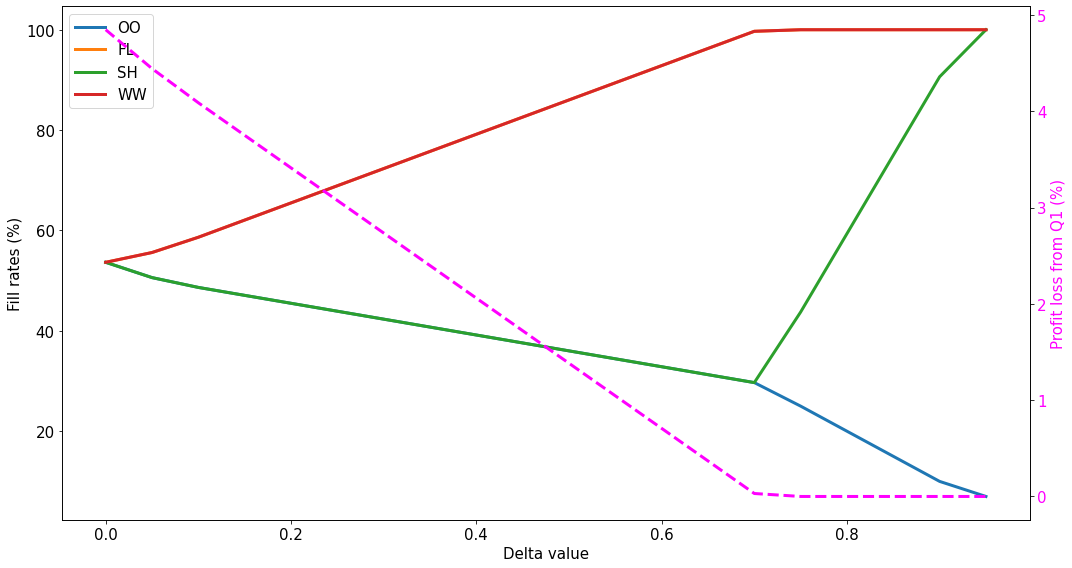

In [ ]:
#@title Examine how the gross profit (losses) depend on the allowed difference
delta_vals = list(np.arange(0,1,0.05))      # set up values for the fill rate (in percentage terms)

# the objective values and the loss compared to Q1
objValues = [0]*len(delta_vals)
loss_Q1 = [0]*len(delta_vals)

# a dictionary with a list for each customer, that stores the realized fill rate at that customer
individual_fillrates = {}   
for r in retailers:
    individual_fillrates[r] = [0]*len(delta_vals)

for i in range(len(delta_vals)):

    # create new model from scratch
    AlsetModel, factoriesToCenters, centersToRetailers, gross_profit, constr = \
          create_model_like_in_Q1()

    AlsetModel.setParam('OutputFlag',0)

    # change the fill rate constraint 
    for r1 in retailers:
      for r2 in retailers:
          AlsetModel.addConstr( 
              quicksum( centersToRetailers[c,r1] for c in centers )/retailersDF["Pre-orders"][r1] - \
              quicksum( centersToRetailers[c,r2] for c in centers )/retailersDF["Pre-orders"][r2] <= \
              delta_vals[i] )
    
    AlsetModel.optimize()   
    objValues[i] = AlsetModel.objVal
    loss_Q1[i] = (1.0 - objValues[i]/gross_profit_Q1)*100
    for r in retailers:
        individual_fillrates[r][i] = (sum(centersToRetailers[c,r].X for c in centers) / retailersDF["Pre-orders"][r])*100  

#@markdown Do a single plot for everything
fontsize = 15
fig, ax1 = plt.subplots(figsize=(15,8))
color1 = 'black'

for r in retailers:
    plt.plot(delta_vals, individual_fillrates[r], linestyle='solid', linewidth=3 )

plt.xlabel("Delta value", fontsize=fontsize)
plt.ylabel("Fill rates (%)", color=color1, fontsize=fontsize)
ax1.tick_params(axis='y', labelcolor=color1)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
ax1.legend(retailers, fontsize=fontsize)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color2 = 'magenta'
ax2.set_ylabel('Profit loss from Q1 (%)', color=color2, fontsize=fontsize)  # we already handled the x-label with ax1
ax2.plot(delta_vals, loss_Q1, color='magenta', linestyle='--', linewidth=3)
ax2.tick_params(axis='y', labelcolor=color2)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)

plt.tight_layout()
plt.show()

______
# **Q6**
Before running this section, make sure you have run all the previous sections of the Colab file.

Here, we require that the fill rate for each retailer is at least as large as some pre-specified lower bound. Mathematically, if $X[c,r]$ denote the shipments from center $c$ to retailer $r$ and $P[r]$ are the pre-orders of $r$, we are imposing the constraint:<br>
> $ \frac{\sum_{c \in \text{C1,C2,C3}} X[c,r]}{P[r]} \geq f$

for some pre-specified value $f$.

In [ ]:
#@title Solve a single problem instance with a minimum fill rate requirement
#@markdown Select the desired minimum fill rate (as a percentage)
min_fill_rate = 29.6 #@param {type:"number"}
min_fill_rate = min_fill_rate/100

#markdown Create a model like the one in Q1
AlsetModel, factoriesToCenters, centersToRetailers, gross_profit, constr = \
       create_model_like_in_Q1()

#@markdown Constrain the fill rate at each retailer
fill_rate_constraint = {}  # store the fill rate constraints in a dictionary, to make it easy to recall them
for r in retailers :
    fill_rate_constraint[r] = \
    AlsetModel.addConstr( quicksum(centersToRetailers[c,r] for c in centers) / retailersDF["Pre-orders"][r] >= min_fill_rate)
        
#@markdown Solve the new model
#@markdown - select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = True #@param {type:"boolean"}

if run_silently:
    AlsetModel.setParam('OutputFlag',0)
else:
    AlsetModel.setParam('OutputFlag',1)

AlsetModel.optimize()
print('\nSolved the optimization problem...\n')

if AlsetModel.status in [GRB.INFEASIBLE, GRB.INF_OR_UNBD]:
    # the model is infeasible
    print("It is infeasible to achieve this fill rate at all retailers.")

elif AlsetModel.status==GRB.OPTIMAL:
    # the model was solved to optimality
    #@markdown Print the gross profit and the difference from Q1
    print_and_compare_Q1(AlsetModel, centersToRetailers)


Solved the optimization problem...

The gross profit with these considerations         : 33,623,200.00
Profit difference compared to Q1:                  : -1,800.00
Profit loss (%):                                   : -0.01
The number of orders and the fill rate at each retailer:

   Retailer 	 Orders 	 Fill rate
   OO     	 1480 		 29.60%
   FL     	 2500 		 100.00%
   SH     	 474 		 29.60%
   WW     	 550 		 100.00%


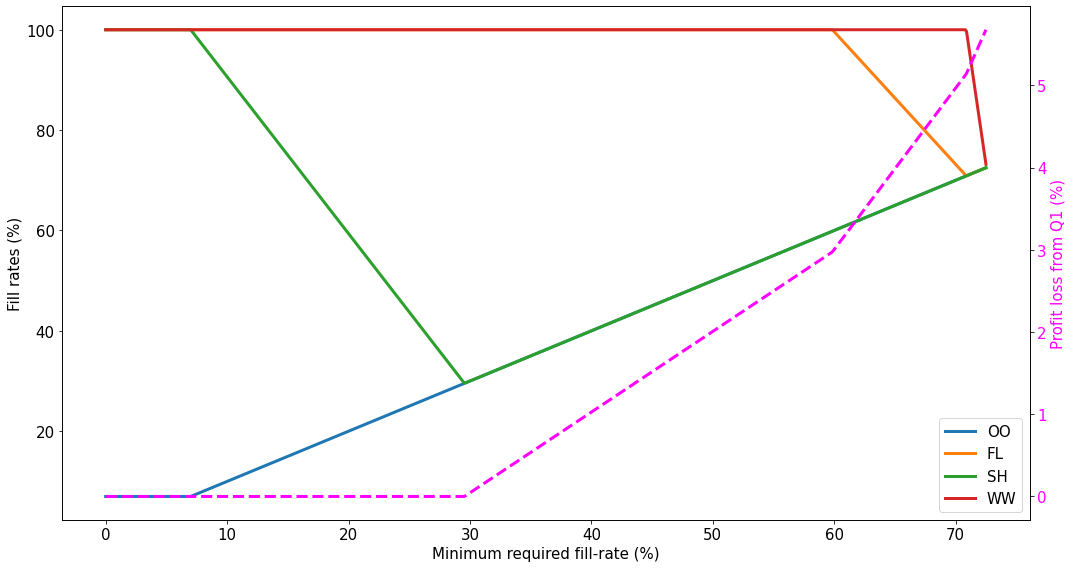

In [ ]:
#@title Examine how the gross profit (losses) depend on the minimum fill rate requirement
fill_rate_vals = list(np.arange(0,72.6,0.1))      # set up values for the fill rate (in percentage terms)

# the objective values and the loss compared to Q1
objValues = [0]*len(fill_rate_vals)
loss_Q1 = [0]*len(fill_rate_vals)

# a dictionary with a list for each customer, that stores the realized fill rate at that customer
individual_fillrates = {}   
for r in retailers:
    individual_fillrates[r] = [0]*len(fill_rate_vals)

for i in range(len(fill_rate_vals)):
    # change the fill rate constraint 
    for r in retailers :
        fill_rate_constraint[r].setAttr('rhs', fill_rate_vals[i]/100)
    
    AlsetModel.optimize()   
    objValues[i] = AlsetModel.objVal
    loss_Q1[i] = (1.0 - objValues[i]/gross_profit_Q1)*100
    for r in retailers:
        individual_fillrates[r][i] = (sum(centersToRetailers[c,r].X for c in centers) / retailersDF["Pre-orders"][r])*100  

#@markdown Do a single plot for everything
fontsize = 15
fig, ax1 = plt.subplots(figsize=(15,8))
color1 = 'black'

for r in retailers:
    plt.plot(fill_rate_vals, individual_fillrates[r], linestyle='solid', linewidth=3 )

plt.xlabel("Minimum required fill-rate (%)", fontsize=fontsize)
plt.ylabel("Fill rates (%)", color=color1, fontsize=fontsize)
ax1.tick_params(axis='y', labelcolor=color1)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.legend(retailers, fontsize=fontsize)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color2 = 'magenta'
ax2.set_ylabel('Profit loss from Q1 (%)', color=color2, fontsize=fontsize)  # we already handled the x-label with ax1
ax2.plot(fill_rate_vals, loss_Q1, color='magenta', linestyle='--', linewidth=3)
ax2.tick_params(axis='y', labelcolor=color2)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)

plt.tight_layout()
plt.show()

______
# **Q7**
Before running this section, make sure you have run all the previous sections of the Colab file.

Here, we change the capacity in each facility (one at a time), resolve the problem, and record the difference in gross profits compared to **Q1**.

In [ ]:
#@title Select by how much to increase the capacity:

capacity_increase = 1 #@param {type:"number"}

for facility in ["Zuffe", "Leip", "C1", "C2", "C3"]:
    #markdown Create a model like the one in Q1
    AlsetModel, factoriesToCenters, centersToRetailers, gross_profit, constr = \
          create_model_like_in_Q1()

    if facility in factories:
        constr["factory_cap"][facility].setAttr('rhs', factoriesDF["Capacity"][facility] + capacity_increase)

    elif facility in centers:
        constr["center_cap"][facility].setAttr('rhs', customizationCentersDF["Capacity"][facility] + capacity_increase)

    # run Gurobi silently
    AlsetModel.setParam('OutputFlag',0)
    AlsetModel.optimize()

    if AlsetModel.status in [GRB.INFEASIBLE, GRB.INF_OR_UNBD]:
        # the model is infeasible
        print("The model is infeasible.")

    elif AlsetModel.status==GRB.OPTIMAL:
        # the model was solved to optimality
        print("By increasing the capacity at {} by {} unit(s), the profit difference compared to Q1 is: {:,.2f}".\
              format(facility, capacity_increase, AlsetModel.objVal - gross_profit_Q1))

By increasing the capacity at Zuffe by 1 unit(s), the profit difference compared to Q1 is: 3,000.00
By increasing the capacity at Leip by 1 unit(s), the profit difference compared to Q1 is: 0.00
By increasing the capacity at C1 by 1 unit(s), the profit difference compared to Q1 is: 6,000.00
By increasing the capacity at C2 by 1 unit(s), the profit difference compared to Q1 is: 1,500.00
By increasing the capacity at C3 by 1 unit(s), the profit difference compared to Q1 is: 0.00


In [ ]:
#@title The code below allows you to visualize how the profit changes as a function of the capacity increase

#@markdown Select one of the facilities
facility = 'C1' #@param ["Zuffe", "Leip", "C1", "C2", "C3"] {allow-input: false}

#@markdown Select by how much to increase the capacity at the facility
capacity_increase = 1 #@param {type:"number"}

#markdown Create a model like the one in Q1
AlsetModel, factoriesToCenters, centersToRetailers, gross_profit, constr = \
       create_model_like_in_Q1()

if facility in factories:
    constr["factory_cap"][facility].setAttr('rhs', factoriesDF["Capacity"][facility] + capacity_increase)

elif facility in centers:
    constr["center_cap"][facility].setAttr('rhs', customizationCentersDF["Capacity"][facility] + capacity_increase)

#@markdown Solve the new model
#@markdown - select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = True #@param {type:"boolean"}

if run_silently:
    AlsetModel.setParam('OutputFlag',0)
else:
    AlsetModel.setParam('OutputFlag',1)

AlsetModel.optimize()
print('\nSolved the new optimization problem...\n')

if AlsetModel.status in [GRB.INFEASIBLE, GRB.INF_OR_UNBD]:
    # the model is infeasible
    print("The model is infeasible.")

elif AlsetModel.status==GRB.OPTIMAL:
    # the model was solved to optimality
    print("The profit difference compared to Q1: {:,.2f}".\
          format(AlsetModel.objVal - gross_profit_Q1))


Solved the new optimization problem...

The profit difference compared to Q1: 6,000.00


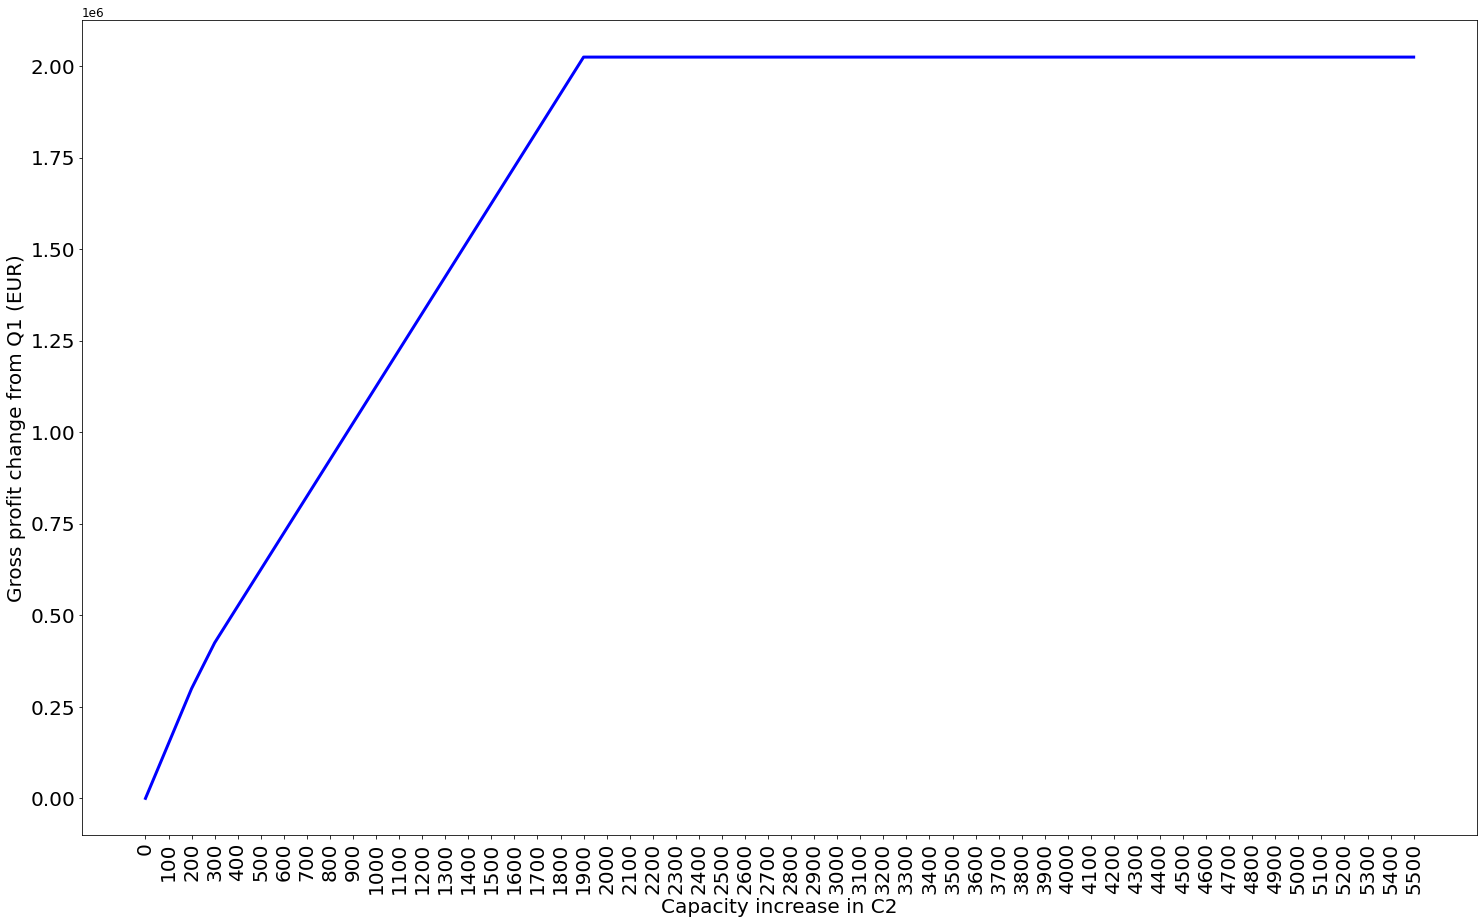

In [ ]:
#@title The code below allows you to visualize how the profit changes as a function of the capacity increase

#@markdown Select one of the facilities
facility = 'C2' #@param ["Zuffe", "Leip", "C1", "C2", "C3"] {allow-input: false}

# set up values for the capacity increase 
cap_increase = list(np.arange(0,5600,100))

# the objective values and the loss compared to Q1
objValues = [0]*len(cap_increase)
change_Q1 = [0]*len(cap_increase)

# Create a model like the one in Q1
AlsetModel, factoriesToCenters, centersToRetailers, gross_profit, constr = \
       create_model_like_in_Q1()

AlsetModel.setParam('OutputFlag', 0)   # supress Gurobi's output

for i in range(len(cap_increase)):
    
    # change capacity at the facility
    if facility in factories:
        constr["factory_cap"][facility].setAttr('rhs', factoriesDF["Capacity"][facility] + cap_increase[i])

    elif facility in centers:
        constr["center_cap"][facility].setAttr('rhs', customizationCentersDF["Capacity"][facility] + cap_increase[i])

    # solve the model
    AlsetModel.optimize()
    
    #print("{:10.2f} : {:10.2f} ".format(cap_increase[i],center_cap_constraints["C1"].pi))

    objValues[i] = AlsetModel.objVal
    #change_Q1[i] = (objValues[i]/gross_profit_Q1 - 1.0)*100
    change_Q1[i] = objValues[i] - gross_profit_Q1

#@markdown Visualize the dependency
fontsize = 20
fig, ax1 = plt.subplots(figsize=(25,15))

# plot the gross profits changes
plt.plot(cap_increase, change_Q1, linestyle='solid', linewidth=3, color='blue' )

plt.xlabel("Capacity increase in " + facility, fontsize=fontsize)
plt.ylabel("Gross profit change from Q1 (EUR)", fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.xticks(ticks=cap_increase, rotation=90)
plt.xticks(fontsize=fontsize)

# calculate the required payments
#plt.legend(("Gross profit change from Q1","Payments for new capacity"),fontsize=30,loc="lower center")
plt.show()